# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-14 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
scipy 0.18.0
sklearn 0.17.1


In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [3]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

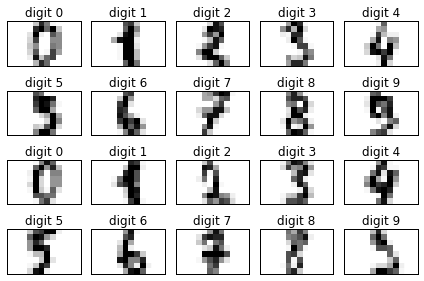

In [4]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [6]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

In [7]:
from sklearn.metrics import accuracy_score, make_scorer

def clustering_accuracy_score(y_true, y_pred):
    # replace this with your code; note that y_pred is just cluster id, not digit id
    y_cm = y_pred
    cluster_label_true = np.unique(y_true)
    cluster_num_true = len(cluster_label_true)
    cluster_label_cm = np.unique(y_cm)
    cluster_num_cm = len(cluster_label_cm)
    
    scores = np.zeros((cluster_num_cm, cluster_num_true))
    
    for i in range(cluster_num_cm):
        for j in range(cluster_num_true):
            y_temp = y_true[y_cm == cluster_label_cm[i]]
            y_count = len(y_temp)
            scores[i][j] = accuracy_score(y_true = y_temp, y_pred = cluster_label_true[j] * np.ones(y_count))
    
    best_assign_index = np.zeros(cluster_num_cm)
    
    for i in range(cluster_num_cm):
        best_assign_index[i] = np.argmax(scores[i])
    
    y_predict = np.zeros(len(y_cm))
    for i, v in enumerate(y_cm):
        index = np.where(cluster_label_cm == v)[0][0]
        y_predict[i] = best_assign_index[index]
    
    return accuracy_score(y_true=y_true, y_pred=y_predict)

clustering_accuracy = make_scorer(clustering_accuracy_score) 

In [8]:
# toy case demonstrating the clustering accuracy
# this is just a reference to illustrate what this score function is trying to achieve
# feel free to design your own as long as you can justify

# ground truth class label for samples
toy_y_true = np.array([0, 0, 0, 1, 1, 2])

# clustering id for samples
toy_y_pred_true = np.array([1, 1, 1, 2, 2, 0])
toy_y_pred_bad1 = np.array([0, 0, 1, 1, 1, 2])
toy_y_pred_bad2 = np.array([2, 2, 1, 0, 0, 0])

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_true)
print('accuracy', toy_accuracy, ', should be 1')

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad1)
print('accuracy', toy_accuracy, ', should be', 5.0/6.0)

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad2)
print('accuracy', toy_accuracy, ', should be', 4.0/6.0)

accuracy 1.0 , should be 1
accuracy 0.833333333333 , should be 0.8333333333333334
accuracy 0.833333333333 , should be 0.6666666666666666


Build a pipeline with standard scaler, PCA, and clustering.

In [9]:
# your code
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# construct a pipeline consisting of different components
# each entry contains an identifier, and the corresponding component
pipe_km = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('km', KMeans(random_state=0))])

Use GridSearchCV to tune hyper-parameters.

In [10]:
# your code
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

param_grid = {'scl__with_mean': [True, False],
              'scl__with_std': [True, False],
              'pca__n_components': np.array(range(20,40,2)),
              'km__n_clusters': np.array(range(10,20)),
              'km__init': ['k-means++', 'random']}
    
gs = GridSearchCV(estimator=pipe_km, 
                  param_grid=param_grid, 
                  scoring=clustering_accuracy, 
                  cv=10,
                  n_jobs=1)

gs = gs.fit(X_train, y_train)

# # below is Li-Yi's dummy code to build a random guess model
# import numpy as np
# class RandomGuesser:
#     def __init__(self, num_classes):
#         self.num_classes = num_classes
#     def predict(self, X):
#         y = np.random.randint(low = 0, high = self.num_classes, size = X.shape[0])
#         return y

In [11]:
best_model = gs.best_estimator_ # replace this with the best model you can build

y_cm = best_model.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_true=y_test, y_pred=y_cm))

#print('Test accuracy: %.3f' % best_model.score(X_test, y_test))

Test accuracy: 0.930


Visualize mis-clustered samples, and provide your explanation.

38 out of 540 samples are mis-clustered.


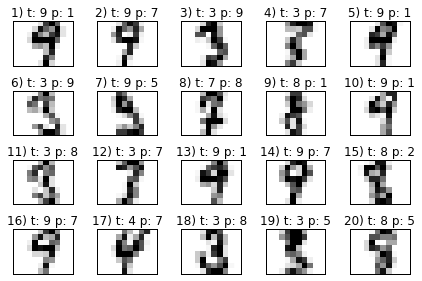

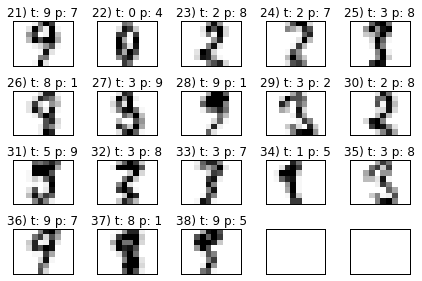

In [12]:
# your code
cluster_label_true = np.unique(y_test)
cluster_num_true = len(cluster_label_true)
cluster_label_cm = np.unique(y_cm)
cluster_num_cm = len(cluster_label_cm)

scores = np.zeros((cluster_num_cm, cluster_num_true))

for i in range(cluster_num_cm):
    for j in range(cluster_num_true):
        y_temp = y_test[y_cm == cluster_label_cm[i]]
        y_count = len(y_temp)
        scores[i][j] = accuracy_score(y_true = y_temp, y_pred = cluster_label_true[j] * np.ones(y_count))

best_assign_index = np.zeros(cluster_num_cm)

for i in range(cluster_num_cm):
    best_assign_index[i] = np.argmax(scores[i])

y_test_pred = np.zeros(len(y_cm))
for i, v in enumerate(y_cm):
        index = np.where(cluster_label_cm == v)[0][0]
        y_test_pred[i] = best_assign_index[index]

miscl_img = X_test[y_test != y_test_pred]
correct_lab = y_test[y_test != y_test_pred]
miscl_lab = y_test_pred[y_test != y_test_pred]
num_miscl = np.count_nonzero(y_test != y_test_pred)
print("%s out of %s samples are mis-clustered." % (num_miscl, num_test))

fig, ax = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(20):
    img = miscl_img[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

fig, ax = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(20, num_miscl):
    img = miscl_img[i].reshape(8, 8)
    ax[i-20].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i-20].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

### your explanation

The reason seem to be obivous, which is that some handwritten digit are really vague or rather similar to other digit. Some digits are even cannot be recognized easily by human. For example, the 7th misclusterred digit '9', the writing is really special and can be confused to other digit. Also, the 19th misclusterred digit '3' is written similarly to '5'. Another example is the 33rd misclusterred digit '3' is almost written as '7'. Besides, some hand-written digit are really vague, including 26th, 28th, 34th, 37th misclustered digit. These are hard to avoid.

On the other hand, it cannot be denied that there are so many digit '9' (nearly 1/3) has been recongized as other digits, especially as '1' and '7'. This may caused by that these three digits all end with a vertical line and the '9' have some obviously different writing style. This problem may be handled better with more number of cluster and better computing resource for trainning. 

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [2]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: 2016-12-14 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
keras 1.1.2


In [1]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing

# X_train = X_train.reshape(num_training_samples, num_img_pixels)
# X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

Using TensorFlow backend.


image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


## Answer

In [10]:
# your code and experimental results

# define a training model
from keras.models import Sequential
model = Sequential()

# number of convolutional filters
n_filters = 96

# convolution filter size
n_conv = 3

# pooling window size
n_pool = 2

In [11]:
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

model.add(Convolution2D(
        n_filters, n_conv, n_conv,

        border_mode='valid',

        # 32x32 rgb channel (3 channel) image
        input_shape=(32, 32, 3),
        
        dim_ordering='tf'
))
model.add(Activation('relu'))

model.add(Convolution2D(n_filters, n_conv, n_conv))
model.add(Activation('relu'))

model.add(Convolution2D(n_filters, n_conv, n_conv))
model.add(Activation('relu'))

# apply pooling
model.add(MaxPooling2D(pool_size=(n_pool, n_pool)))


model.add(Dropout(0.25))

# flatten the data for the 1D layers
model.add(Flatten())

# Dense(n_outputs)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax output layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 50, 
              batch_size = 1024, 
              verbose = True, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 15s - loss: 1.9996 - acc: 0.2644 - val_loss: 1.7158 - val_acc: 0.3896
Epoch 2/50
45000/45000 [==============================] - 12s - loss: 1.7197 - acc: 0.3786 - val_loss: 1.5387 - val_acc: 0.4444
Epoch 3/50
45000/45000 [==============================] - 12s - loss: 1.5864 - acc: 0.4285 - val_loss: 1.4118 - val_acc: 0.4890
Epoch 4/50
45000/45000 [==============================] - 12s - loss: 1.4867 - acc: 0.4644 - val_loss: 1.3299 - val_acc: 0.5322
Epoch 5/50
45000/45000 [==============================] - 12s - loss: 1.4296 - acc: 0.4881 - val_loss: 1.2771 - val_acc: 0.5424
Epoch 6/50
45000/45000 [==============================] - 12s - loss: 1.3609 - acc: 0.5130 - val_loss: 1.2485 - val_acc: 0.5584
Epoch 7/50
45000/45000 [==============================] - 12s - loss: 1.3225 - acc: 0.5325 - val_loss: 1.1997 - val_acc: 0.5742
Epoch 8/50
45000/45000 [==============================]

In [13]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)

First few predictions:  [6 9 9]
Training accuracy: 0.89382
Test accuracy: 0.7081


## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optpimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>

### Introduction

In this part of assignment, I have chose convolutional neural network (CNN) for the image classification. As a result of the constructure of multilayer perceptrons, associated weight and pooling layer, the CNN can ultilize the 2-dimentional structrue of input data, so as that the CNN can have better trainning outcome in the fields of image and video recognization, and natural language processing. Thus, to deal with the problem of image classification, convolutional neural network should be the best choice.

### Method

1. Data preprocessing: The image data is handled as 2D data, and we have scale the data range from [0, 255] to [0, 1] for the future processing.
2. Other parameters and models are chose and tested manually to find better ones.

### Results

After confirm the training model as convolutional neural network, I firstly instantiate a sequential Keras model, trying to constuct a baisc neural network to implement a training model. And then added different layers one after the other, including filter, pooling and so on.

At first I follow the gerneral architecture of a convolutional neural network and specify the architecture hyperparemeters as the common settings, and using two convolution layers. But the test accuracy is not satisfying, the accuracy is only about 50%. 

It seems that the model is too simple for such a task, so I add more filters to the model, from 32 to 64 then to 96 and 128. when the filter number comes to be over, the validation accuracy is higher but the test accuracy remains even deceased, which is a signal of over-fitting. After test, the best number of filters is around 96. The accurary increased to near 69%.

One the other hand, only two convolution layers is also too simple for the 32x32 3 channel data, so I try to add one more convolution layer. Together with modifying other hyperparemeters including the convolution filter size and pooling window size, the test accuracy of my model is over 70%.

### Conclusion

The final test accuracy approches 71%, but it is still too early to come with a conclusion. This accuracy is just passable but the room for improvement is still large. 

However, from the experimental process, I have learnt that the general architecture of a convolustional neural network. And there is a principle that, the more complex task, the more  convolution layer, the more convolutional filters, the larger convolutional filter size, the larger pooling window size we need, and so on. But should not be over, which could cause the over-fit.

### References

1. Ml4a. "Convolutional Neural Networks: MNIST Classification with Keras." Convolutional Neural Networks: MNIST Classification with Keras. N.p., n.d. Web. 14 Dec. 2016. http://ml4a.github.io/guides/convolutional_neural_networks/

2. Scalable Bayesian Optimization Using Deep Neural Networks